# Bar test


In [1]:
import cmcrameri.cm as cmc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.compound import Compound, field

EPS = 1e-12

In [2]:
from typing import NamedTuple

from femsolver.operator import OperatorUpdatedLagrangian


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


n = 30
E = 1
nu = 0.3
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

mesh = Mesh.rectangle((0, 10), (0, 1), 40, 5)
tri = element.Tri3()
op = Operator(mesh, tri)
material = Material(mu=mu, lmbda=lmbda)


n_nodes = mesh.coords.shape[0]
# contact nodes are those nodes on the left edge of the mesh
contact_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
n_lambda = contact_nodes.size


class Solution(Compound):
    u = field(shape=(n_nodes, 2))


sol = Solution()
sol

Solution(u=(246, 2))

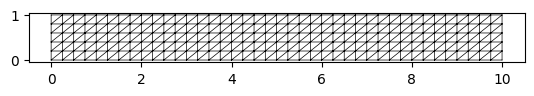

In [3]:
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

In [ ]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the Green-Lagrange strain tensor from the displacement gradient."""
    F = jnp.eye(2) + grad_u  # Deformation gradient
    C = F.T @ F  # Right Cauchy-Green tensor
    return 0.5 * (C - jnp.eye(2))


@auto_vmap(grad_u=2)
def compute_stress(grad_u: Array, mat: Material) -> Array:
    """Compute the 2nd Piola-Kirchhoff stress tensor for a compressible Neo-Hookean material."""
    F = jnp.eye(2) + grad_u
    J = jnp.linalg.det(F)
    C = F.T @ F
    C_inv = jnp.linalg.inv(C)
    S = mat.mu * (jnp.eye(2) - C_inv) + mat.lmbda * jnp.log(J) * C_inv
    return S


@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mat: Material) -> Array:
    """Neo-Hookean strain energy density (compressible)."""
    F = jnp.eye(2) + grad_u
    J = jnp.linalg.det(F)
    Ic = jnp.trace(F.T @ F)
    return (
        0.5 * mat.mu * (Ic - 2)
        # - mat.mu * jnp.log(J)
        # + 0.5 * mat.lmbda * (jnp.log(J)) ** 2
    )


@auto_vmap(grad_u=2)
def J(grad_u: Array) -> Array:
    """Compute the determinant of the deformation gradient."""
    F = jnp.eye(2) + grad_u
    return jnp.linalg.det(F)


def total_energy(uflat: Array, mat: Material, op: Operator) -> Array:
    (u,) = Solution(uflat)
    strain_energy_density = strain_energy(op.grad(u), mat)
    return op.integrate(strain_energy_density)


residual = jax.grad(total_energy, argnums=0)
hessian = jax.jacfwd(residual)

In [22]:
def linear_solve(K: Array, rhs, bc_dofs, bc_values) -> Array:
    jax.debug.print("Solving linear system with {n} dofs", n=K.shape[0])
    K = K.at[bc_dofs, :].set(0)
    K = K.at[:, bc_dofs].set(0)
    K = K.at[bc_dofs, bc_dofs].set(1.0)

    rhs = rhs.at[bc_dofs].set(bc_values)
    return jnp.linalg.solve(K, rhs)


def solve_nr(
    sol: Solution,
    bc_dofs: Array,
    bc_values: Array,
    op: Operator,
    *,
    maxiter: int = 20,
    tol: float = 1e-6,
) -> Solution:
    uflat_init = sol.arr.at[bc_dofs].set(bc_values)
    res = residual(uflat_init, material, op).at[bc_dofs].set(0.0)
    norm = jnp.linalg.norm(res)

    @jax.jit
    def cond_fn(carry: tuple) -> bool:
        *_, norm, i = carry
        jax.debug.print(
            "Residual norm: {norm} [it: {it}]",
            norm=norm,
            it=i,
        )
        return (norm > tol) & (i < maxiter)

    @jax.jit
    def body_fn(
        carry: tuple[Solution, Operator, float, int],
    ) -> tuple:
        sol, op, norm, i = carry

        delta = Solution(
            linear_solve(
                hessian(sol.arr, material, op),
                -residual(sol.arr, material, op),
                bc_dofs,
                bc_values - sol.arr[bc_dofs],
            )
        )
        new = sol + delta

        res = residual(new.arr, material, op).at[bc_dofs].set(0.0)
        norm = jnp.linalg.norm(res)

        return (new, op, norm, i + 1)

    sol, op, norm, i = jax.lax.while_loop(cond_fn, body_fn, (sol, op, norm, 0))
    return sol

In [23]:
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 10.0))[0]
right_dofs = Solution.u.idx[right_nodes, :]

left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
left_dofs = Solution.u.idx[left_nodes, :]
left_values = jnp.zeros((left_nodes.size, 2))

op = Operator(mesh, tri)
sol = Solution()

p_11 = []
p_11.append(0)


xi = jnp.linspace(1, 1.2, 10)
for x in xi[1:]:
    du_right = 10 * x - 10
    right_values = jnp.zeros((right_nodes.size, 2)).at[:, 0].set(du_right)

    print(f"--------------------------------------")
    print(f"Solving for right displacement: {du_right} mm")
    print(f"--------------------------------------")

    sol = solve_nr(
        sol,
        jnp.concatenate([right_dofs, left_dofs]),
        jnp.concatenate([right_values, left_values]).flatten(),
        op,
        maxiter=10,
        tol=1e-6,
    )

    F = op.grad(sol.u) + jnp.eye(2)
    S = compute_stress(op.grad(sol.u), material)
    cauchy = F @ S @ F.swapaxes(-1, -2)

    p_11.append(cauchy.squeeze()[:, 0, 0].mean())

--------------------------------------
Solving for right displacement: 0.22222222222222143 mm
--------------------------------------
Residual norm: 1.7590396429251458 [it: 0]
Solving linear system with 492 dofs
Residual norm: 1.0213122486251125 [it: 1]
Solving linear system with 492 dofs
Residual norm: 0.25819310345120466 [it: 2]
Solving linear system with 492 dofs
Residual norm: 0.031409787495173126 [it: 3]
Solving linear system with 492 dofs
Residual norm: 0.0002975267020524041 [it: 4]
Solving linear system with 492 dofs
Residual norm: 1.4157041971625802e-07 [it: 5]
--------------------------------------
Solving for right displacement: 0.44444444444444464 mm
--------------------------------------
Residual norm: 0.2273578513325118 [it: 0]
Solving linear system with 492 dofs
Residual norm: 0.22735785101743855 [it: 1]
Solving linear system with 492 dofs
Residual norm: 0.012523897359778267 [it: 2]
Solving linear system with 492 dofs
Residual norm: 7.231625836892846e-05 [it: 3]
Solving li

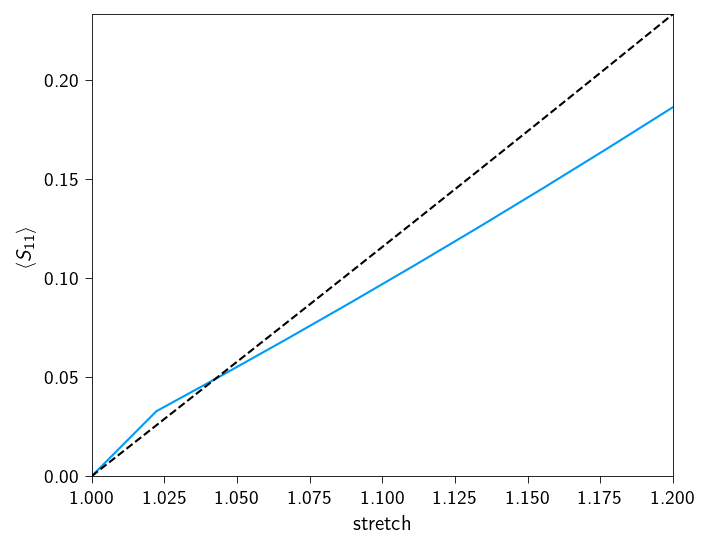

In [24]:
def analytical_stress_engineering(stretch: float) -> float:
    return material.mu * (stretch**2 - 1 / stretch)


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

ax.plot(xi, p_11)
ax.plot(
    xi,
    analytical_stress_engineering(xi),
    "--",
    color="k",
    label="Analytical",
)
ax.set(xlabel="stretch", ylabel=r"$\langle S_{11}\rangle$")
ax.margins(0)

In [25]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(sol.u).squeeze()
strains = compute_strain(grad_u)
sig = compute_stress(strains, material)
sig_vm = von_mises_stress(sig)

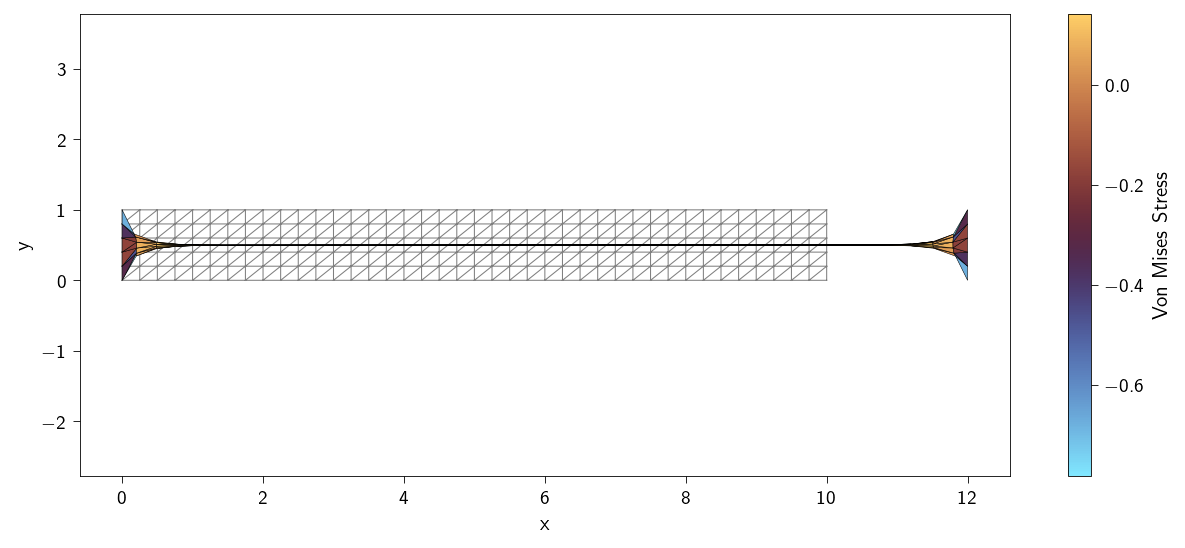

In [26]:
from matplotlib.pyplot import xlabel
from femsolver.plotting import STYLE_PATH
from matplotlib.axes import Axes

plt.style.use(STYLE_PATH)


def plot_displacement_and_stress(
    ax: Axes, u: Array, mesh: Mesh, stress: Array, scale=1.0
) -> None:
    coords, elements = mesh.coords, mesh.elements
    displaced = coords + scale * u

    ax.triplot(
        coords[:, 0], coords[:, 1], elements, color="k", alpha=0.5, linewidth=0.5
    )
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(cb, label="Von Mises Stress")
    ax.set(xlabel="x", ylabel="y")
    ax.axis("equal")


fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

plot_displacement_and_stress(ax, sol.u, mesh, sig[:, 0, 0])

### Rigid body rotation


In [15]:
def rigid_body_rotation_displacement_2d(
    X: Array, angle: float, center: Array = jnp.array([0.0, 0.0])
) -> Array:
    c = jnp.cos(angle)
    s = jnp.sin(angle)
    R = jnp.array([[c, -s], [s, c]])
    Xc = X - center
    rotated = (R @ Xc.T).T + center
    return rotated - X


u = rigid_body_rotation_displacement_2d(
    mesh.coords, jnp.pi / 4, center=jnp.array([0.5, 0.5])
)

op = OperatorUpdatedLagrangian(mesh, tri, u)
op2 = Operator(mesh, tri)
neo_hookean_energy(op.grad(u), material)

Array([[-1.11022302e-16],
       [ 7.09974815e-30],
       [ 1.20794326e-30],
       ...,
       [ 2.22044605e-16],
       [ 1.97215226e-31],
       [ 7.88860905e-31]], dtype=float64)

In [ ]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u).squeeze()
strains = compute_strain(grad_u)
sig = compute_stress(strains, material)
sig_vm = von_mises_stress(sig)

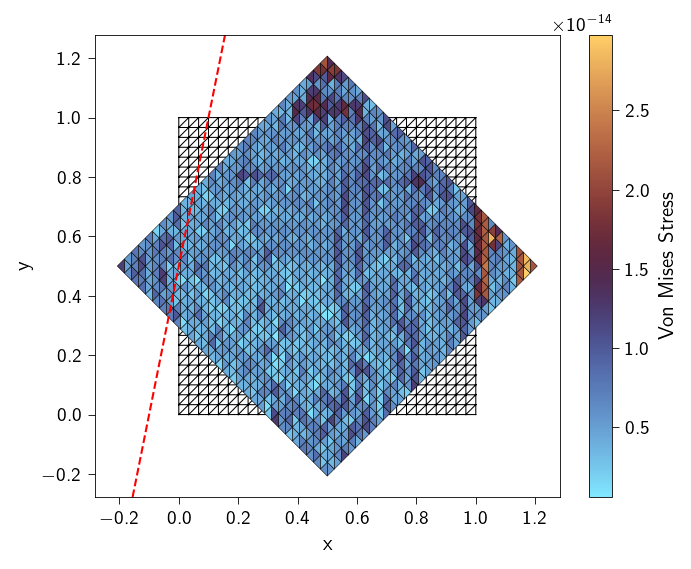

In [ ]:
from matplotlib.pyplot import xlabel
from femsolver.plotting import STYLE_PATH
from matplotlib.axes import Axes

plt.style.use(STYLE_PATH)


def plot_displacement_and_stress(
    ax: Axes, u: Array, mesh: Mesh, stress: Array, scale=1.0
) -> None:
    coords, elements = mesh.coords, mesh.elements
    displaced = coords + scale * u

    ax.triplot(
        coords[:, 0],
        coords[:, 1],
        elements,
        color="black",
        linewidth=0.5,
    )
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(cb, label="Von Mises Stress")
    ax.set(xlabel="x", ylabel="y")
    ax.axis("equal")

    # Plot the gap=0 contour (the contact surface)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    pts = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    G = gap(pts).reshape(X.shape)
    ax.contour(X, Y, G, levels=[0], colors="red", linewidths=1, linestyles="--")


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plot_displacement_and_stress(ax, u, mesh, sig_vm)